In [1]:
# script that generates a button to hide all code
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Toggle Code"></form>''')

In [7]:
import os 
import warnings
warnings.simplefilter(action = "ignore", category = UserWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import pymc as pm

from sqlalchemy import create_engine
engine_string = os.environ['REDSHIFT_CONN']
engine = create_engine(engine_string)

pd.options.display.max_columns=100
pd.options.mode.chained_assignment = None

#################################

# Displays a list of experiments to choose from, not that the first 3 we have logged are removed
# due to our mapped_experiments table not starting to build until May 10th. Before this,
# we were generating too many experiment events.

def sql(query):
    return pd.read_sql("%s" %query, engine)

# list of experiments in database
experiment_list = (sql("""
    SELECT DISTINCT experiment_name
    FROM force_production.experiment_viewed
    WHERE experiment_name != 'partner_application_copy'
    AND experiment_name   != 'masonry_artwork_sort'
    AND experiment_name   != 'artwork_item_contact_gallery'
"""))

# Variations; this is necessary because of of the inconsistencies in the experiments table for variation_name for the default group
defaults = ['default', 'original',
            'old_homepage_1', 'old_homepage_2', 'old_homepage_3', 'old_homepage_4', 'old_homepage_5']

def query_experiment_data(exp_name):

    # pulls the first and last experiment logged
    start_end = sql("""
        SELECT MIN(sent_at),
               MAX(sent_at)
        FROM force_production.experiment_viewed
        WHERE experiment_name = '%s'
    """%exp_name)

    # selects the value from the data frame
    first_log_of_exp = start_end.iloc[0]['min']
    last_log_of_exp = start_end.iloc[0]['max']

    # finds the start and end date
    print 'start date:                     ', first_log_of_exp
    print 'max date:                       ', last_log_of_exp
    print '-'*70

    # input for start and end date
    start_date = raw_input("type in experiment start date:   ")
    end_date =   raw_input("type in experiment end date:     ")

    # queries the experiment table
    exp = sql("""
        SELECT exp.variation_id,
               fins.*,
               SPLIT_PART(fins.session_id,' - ',1) as session_number
        FROM (SELECT DISTINCT session_id,
                     variation_id,
                     experiment_id
              FROM analytics.force_mapped_experiment_viewed afmev
              WHERE afmev.experiment_id = '%s') exp
          LEFT JOIN analytics.force_inquiry_funnel_sessions fins
                 ON exp.session_id = fins.session_id
                AND exp.variation_id is not null
        WHERE (session_start_at >= '%s' AND session_start_at <= '%s') LIMIT 5000000
    """%(exp_name, start_date, end_date))
    
    print
    print "experiment runs for " + str(exp.session_start_at.max()-exp.session_start_at.min())
    print '-'*70
    
    exp['date'] = exp.session_start_at.values.astype('datetime64[D]')
    exp['session_number'] = exp.session_number.values.astype(int)
    exp['outcome'] = (exp.inquiries > 0).astype('int')
    exp = exp.set_index('session_start_at').sort_index()
    
    return exp

def control_test_split(exp):
    control = exp.loc[exp.variation_id.isin(defaults)]
    test = exp.loc[~exp.variation_id.isin(defaults)]

    return control, test

def generate_metrics(control,test):
    control_lvid_positive = len(control.loc[control.inquiries>0].groupby('looker_visitor_id').inquiries.count())
    test_lvid_positive    = len(test.loc[test.inquiries>0].groupby('looker_visitor_id').inquiries.count())

    metrics = { 'number of uniques:': [control.looker_visitor_id.nunique(), test.looker_visitor_id.nunique()],
                'number of sessions': [len(control), len(test)],
                'uniques that have inquired': [control_lvid_positive, test_lvid_positive],
                'sessions resulting in inquiry': [control.outcome.sum(), test.outcome.sum()],
                'total artwork pageviews / uniques': [control.count_artwork_pv.sum()*1./control.looker_visitor_id.nunique(),test.count_artwork_pv.sum()*1./control.looker_visitor_id.nunique()],
                'sum of inquiries / # of sessions': [1.*control.inquiries.sum()/control.session_id.nunique(), 1.*test.inquiries.sum()/test.session_id.nunique()],
                'sum of inquiries / # of uniques': [1.*control.inquiries.sum() / control.looker_visitor_id.nunique(), 1.*test.inquiries.sum() / test.looker_visitor_id.nunique()],
                'avg inquiry rate per unique': [ 1.*int(control.groupby('looker_visitor_id').inquiries.mean().sum())/control.looker_visitor_id.nunique(), 1.*int(test.groupby('looker_visitor_id').inquiries.mean().sum())/test.looker_visitor_id.nunique()]
               }

    df_metrics = pd.DataFrame(metrics)
    cols = df_metrics.columns.tolist()
    cols = cols[1:] + cols[0:1]
    cols = cols[0:3] + cols[6:7] + cols[3:6] + cols[-1:]
    df_metrics = df_metrics[cols]
    df_metrics = df_metrics.T
    df_metrics.columns = [['control', 'test']]
    print df_metrics
    print

    control_sum = pd.DataFrame(control.ix[:,12:22].sum(), columns=['control'])
    test_sum = pd.DataFrame(test.ix[:,12:22].sum(), columns=['test'])
    print pd.merge(control_sum,test_sum,left_index=True,right_index=True)
    print 

    metrics = { 'positive LVID outcomes / uniques': [1.*control_lvid_positive/control.looker_visitor_id.nunique(),1.*test_lvid_positive/test.looker_visitor_id.nunique()],
                'positive sessions / total sessions': [1.*control.outcome.sum()/control.session_id.nunique(),1.*test.outcome.sum()/test.session_id.nunique()]
               }

    df_metrics = pd.DataFrame(metrics).T
    df_metrics.columns = [['control', 'test']]
    print df_metrics
    print '-'*70
    print

def cumulative_plot(test, control):
    # plots cumulative metrics from the inquiry_sessions funnel
    fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(14,16), sharex=True)
    plt.suptitle('Cumulative Metrics', fontsize=30); 
    # plt.style.use('classic')

    test.count_pv.cumsum().plot(ax=axes[0,0], title='pageviews', legend=True, label='test')
    control.count_pv.cumsum().plot(ax=axes[0,0], legend=True, label='control')

    test.count_artwork_pv.cumsum().plot(ax=axes[0,1], title='artwork pageviews', legend=True, label='test')
    control.count_artwork_pv.cumsum().plot(ax=axes[0,1], legend=True, label='control')

    test.count_artist_pv.cumsum().plot(ax=axes[1,0], title='artist pageviews', legend=True, label='test')
    control.count_artist_pv.cumsum().plot(ax=axes[1,0], legend=True, label='control')

    test.count_article_pv.cumsum().plot(ax=axes[1,1], title='article pageviews', legend=True, label='test')
    control.count_article_pv.cumsum().plot(ax=axes[1,1], legend=True, label='control')

    test.inquiries.cumsum().plot(ax=axes[2,0], title='inquiries', legend=True, label='test')
    control.inquiries.cumsum().plot(ax=axes[2,0], legend=True, label='control')

    test.accounts_created.cumsum().plot(ax=axes[2,1], title='accounts created', legend=True, label='test')
    control.accounts_created.cumsum().plot(ax=axes[2,1], legend=True, label='control')

    test.three_way_handshakes.cumsum().plot(ax=axes[3,0], title='three way handshakes', legend=True, label='test')
    control.three_way_handshakes.cumsum().plot(ax=axes[3,0], legend=True, label='control')

    test.three_way_handshakes_within_seven_days.cumsum().plot(ax=axes[3,1], title='three way handshakes within 7 days', legend=True, label='test')
    control.three_way_handshakes_within_seven_days.cumsum().plot(ax=axes[3,1], legend=True, label='control')

    test.purchases.cumsum().plot(ax=axes[4,0], title='purchases', legend=True, label='test')
    control.purchases.cumsum().plot(ax=axes[4,0], legend=True, label='control')

    test.total_purchase_price.cumsum().plot(ax=axes[4,1], title='total purchase price', legend=True, label='test')
    control.total_purchase_price.cumsum().plot(ax=axes[4,1], legend=True, label='control')
    
def daily_plot(test,control):
    fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(12,14), sharex=True)
    plt.suptitle('Daily Metrics', fontsize=30); 

    test.groupby('date')['count_pv'].sum().plot(kind='line', ax=axes[0,0], title='pageviews', legend=True, label='test', color='red')
    control.groupby('date')['count_pv'].sum().plot(kind='line', ax=axes[0,0], legend=True, label='control', color='steelblue')

    test.groupby('date')['count_artwork_pv'].sum().plot(kind='line', ax=axes[0,1], title='artwork pageviews', legend=True, label='test', color='red')
    control.groupby('date')['count_artwork_pv'].sum().plot(kind='line', ax=axes[0,1], legend=True, label='control', color='steelblue')

    test.groupby('date')['count_artist_pv'].sum().plot(kind='line', ax=axes[1,0], title='artist pageviews', legend=True, label='test', color='red')
    control.groupby('date')['count_artist_pv'].sum().plot(kind='line', ax=axes[1,0], legend=True, label='control', color='steelblue')

    test.groupby('date')['count_article_pv'].sum().plot(kind='line', ax=axes[1,1], title='article pageviews', legend=True, label='test', color='red')
    control.groupby('date')['count_article_pv'].sum().plot(kind='line', ax=axes[1,1], legend=True, label='control', color='steelblue')

    test.groupby('date')['inquiries'].sum().plot(kind='line',ax=axes[2,0], title='inquiries', legend=True, label='test', color='red')
    control.groupby('date')['inquiries'].sum().plot(kind='line',ax=axes[2,0], legend=True, label='control', color='steelblue')

    test.groupby('date')['accounts_created'].sum().plot(kind='line', ax=axes[2,1], title='accounts created', legend=True, label='test', color='red')
    control.groupby('date')['accounts_created'].sum().plot(kind='line', ax=axes[2,1], legend=True, label='control', color='steelblue')

    test.groupby('date')['three_way_handshakes'].sum().plot(kind='line', ax=axes[3,0], title='three way handshakes', legend=True, label='test', color='red')
    control.groupby('date')['three_way_handshakes'].sum().plot(kind='line', ax=axes[3,0], legend=True, label='control', color='steelblue')

    test.groupby('date')['three_way_handshakes_within_seven_days'].sum().plot(kind='line', ax=axes[3,1], title='three way handshakes within 7 days', legend=True, label='test', color='red')
    control.groupby('date')['three_way_handshakes_within_seven_days'].sum().plot(kind='line', ax=axes[3,1], legend=True, label='control', color='steelblue')

    test.groupby('date')['purchases'].sum().plot(kind='line', ax=axes[4,0], title='purchases', legend=True, label='test', color='red')
    control.groupby('date')['purchases'].sum().plot(kind='line', ax=axes[4,0], legend=True, label='control', color='steelblue')

    test.groupby('date')['total_purchase_price'].sum().plot(kind='line', ax=axes[4,1], title='total purchase price', legend=True, label='test', color='red')
    control.groupby('date')['total_purchase_price'].sum().plot(kind='line', ax=axes[4,1], legend=True, label='control', color='steelblue')

def credible_intervals(control, test):

    # Bayesian approach to show the probability of the control being better or worse than the test
    # This looks at whether or not a user placed an inquiry - this avoids bias in people that send more inquiries

    first_inquiry_control = pd.DataFrame(control.loc[control.outcome ==1].
                                         groupby(['looker_visitor_id']).date.min().reset_index())
    first_inquiry_test = pd.DataFrame(test.loc[test.outcome ==1].
                                         groupby(['looker_visitor_id']).date.min().reset_index())
    first_inqs_per_day_control = first_inquiry_control.groupby('date').count()
    first_inqs_per_day_test = first_inquiry_test.groupby('date').count()

    # cumulative list of inquiries per day; only using the first inquiry from a given Looker Visitor ID
    inq_A = first_inqs_per_day_control.cumsum().looker_visitor_id.tolist()
    inq_B = first_inqs_per_day_test.cumsum().looker_visitor_id.tolist()

    # cumulative list of unique Looker Visitor IDs per day; only using the first observed instance
    control_A = pd.DataFrame(control.
                             groupby('looker_visitor_id').date.min().reset_index()).groupby('date')['looker_visitor_id'].count().cumsum().tolist()
    test_B = pd.DataFrame(test.
                          groupby('looker_visitor_id').date.min().reset_index()).groupby('date')['looker_visitor_id'].count().cumsum().tolist()

    #containers for HPD intervals
    hpds_A = []
    hpds_B = []

    # print '-'*30 + 'HPD intervals' + '-'*30

    # runs MCMC for each day the test is running; control_A has a value for each day in the test
    for i in range(0,len(control_A)):

    # assign distributions to my prior beliefs of p_A and p_B, the unknown, true conversion rates.
    # Assume uniform distribution (no prior knowledge of what p_A and 'p_B' are).
        p_A = pm.Uniform('p_A', lower=0, upper=1)
        p_B = pm.Uniform('p_B', lower=0, upper=1)

        # Since estimating the difference in true conversion rates, define a variable delta, which equals p_B - p_A.
        @pm.deterministic
        def delta(p_A=p_A, p_B=p_B):
            return p_B - p_A

    # To format this data for the analysis, create array with 1s representing inquiries and 0s representing no inquiries
    # np.r_ translates slice objects to concatenation along the first axis and allows us to build arrays quickly
    # If the index expression contains comma separated arrays, then stack them along their first axis.
    # If the index expression contains slice notation or scalars then create a 1-D array with a range indicated by the slice notation.

        data_A = np.r_[[0] * (control_A[i]- inq_A[i]), [1] * inq_A[i]]
        data_B = np.r_[[0] * (test_B[i] - inq_B[i]), [1] * inq_B[i]]

    # Add the observed data to PyMC variables and run MCMC for inference
        obs_A = pm.Bernoulli("obs_A", p_A, value = data_A, observed = True)
        obs_B = pm.Bernoulli("obs_B", p_B, value = data_B, observed = True)

        mcmc = pm.MCMC([p_A, p_B, delta, obs_A, obs_B])
        mcmc.sample(25000, 5000)

        p_A_samples = mcmc.trace("p_A")[:]
        p_B_samples = mcmc.trace("p_B")[:]
        delta_samples = mcmc.trace("delta")[:]

    # get HPD intervals
        hpd_A = pm.utils.hpd(p_A_samples, 1.-0.95)
        hpd_B = pm.utils.hpd(p_B_samples, 1.-0.95)

        hpds_A.append(hpd_A)
        hpds_B.append(hpd_B)
        print

    dfA = pd.DataFrame(hpds_A)
    dfB = pd.DataFrame(hpds_B)

    print
    # A 100(1-alpha)% HPD (highest posterior density) interval is a region that satisfies the following two conditions:
    #  1. The posterior probability of that region is 100(1-alpha)%.
    #  2. The minimum density of any point within that region is equal to or larger than the density of any point outside that region.

    # alpha is the tightness of the interval; the amount of probabilty mass excluded from the interval
    print mcmc.summary()

    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(14,8), sharex=True)

    plt.fill_between(dfA.index, dfA[0], dfA[1], alpha=0.2, color='b')
    plt.fill_between(dfB.index, dfB[0], dfB[1], alpha=0.2, color='r')
    
    return p_A_samples, p_B_samples, delta_samples
    
def compare_posterior_distributions(p_A_samples, p_B_samples, delta_samples):
    from IPython.core.pylabtools import figsize

    figsize(12.5, 10)

    ax = plt.subplot(311)

    plt.xlim(0, p_A_samples.max()+.01)
    plt.hist(p_A_samples, histtype='stepfilled', bins=25, alpha=0.5,
    label="posterior of $p_A$", color="#A60628", normed=True,
    edgecolor= "none")
    plt.legend(loc="upper right")
    plt.title("Posterior distributions of $p_A$, $p_B$, and delta unknowns")

    ax = plt.subplot(312)

    plt.xlim(0, p_B_samples.max()+.01)
    plt.hist(p_B_samples, histtype='stepfilled', bins=25, alpha=0.5,
            label="posterior of $p_B$", color="#467821", normed=True,
            edgecolor = "none")
    plt.legend(loc="upper right")

    ax = plt.subplot(313)
    plt.ylim(0,120)
    plt.hist(delta_samples, histtype='stepfilled', bins=50, alpha=0.5,
            label="posterior of $p_B$ - $p_A$", color="#7A68A6",normed=True,
            edgecolor = "none")
    plt.legend(loc="upper right")
    plt.vlines(0, 0, 120, color="black", alpha = .5)

    plt.show()

    print "Probability control is BETTER than test: %.3f" %(delta_samples < 0).mean()
    print "Probability control is WORSE than test: %.3f" %(delta_samples > 0).mean()

In [2]:
print experiment_list
print 

# input for experiment name
exp_name = raw_input("type in an experiment name:      ")

# queries data from experiment
exp = query_experiment_data(exp_name)

# splits data into test and control buckets
control, test = control_test_split(exp)

# generates positive hits -- number of unique LVIDs that have placed inquiries
generate_metrics(control, test)

           experiment_name
0    personalized_homepage
1  redesigned_artwork_page

type in an experiment name:      personalized_homepage
start date:                      2016-07-15 15:41:08
max date:                        2016-08-12 13:42:53
----------------------------------------------------------------------
type in experiment start date:   2016-07-21
type in experiment end date:     2016-08-12

experiment runs for 21 days 23:57:44
----------------------------------------------------------------------
                                        control          test
number of sessions                 29980.000000  30155.000000
number of uniques:                 24403.000000  24447.000000
sessions resulting in inquiry        190.000000    193.000000
uniques that have inquired           183.000000    187.000000
sum of inquiries / # of sessions       0.009239      0.011242
sum of inquiries / # of uniques        0.011351      0.013867
total artwork pageviews / uniques      1.587920      1.

 [-----------------100%-----------------] 25000 of 25000 complete in 3.9 sec
 [-----------------100%-----------------] 25000 of 25000 complete in 4.2 sec
 [-----------------100%-----------------] 25000 of 25000 complete in 5.0 sec
 [-----------------100%-----------------] 25000 of 25000 complete in 4.8 sec
 [-----------------100%-----------------] 25000 of 25000 complete in 5.6 sec
 [-----------------100%-----------------] 25000 of 25000 complete in 6.4 sec
 [-----------------100%-----------------] 25000 of 25000 complete in 6.8 sec
 [-----------------100%-----------------] 25000 of 25000 complete in 7.9 sec
 [-----------------100%-----------------] 25000 of 25000 complete in 8.1 sec
 [-----------------100%-----------------] 25000 of 25000 complete in 9.1 sec
 [-----------------100%-----------------] 25000 of 25000 complete in 9.6 sec
 [-----------------100%-----------------] 25000 of 25000 complete in 9.8 sec
 [-----------------100%-----------------] 25000 of 25000 complete in 10.3 se

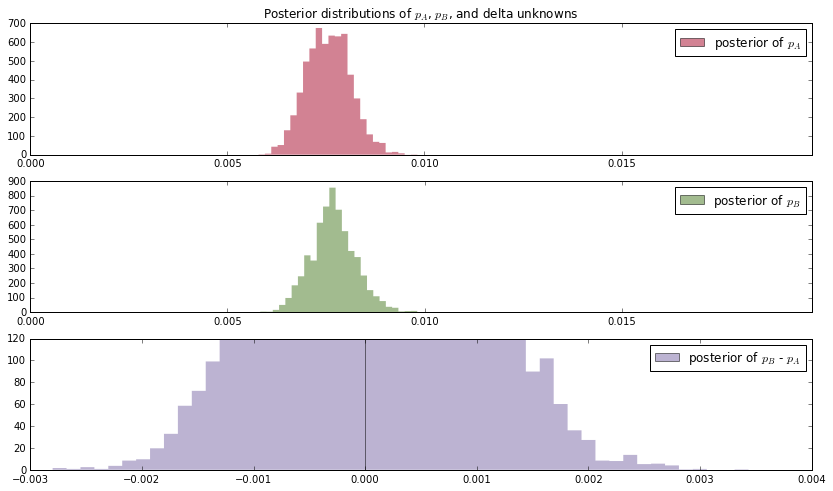

Probability control is BETTER than test: 0.431
Probability control is WORSE than test: 0.569


In [10]:
p_A_samples, p_B_samples, delta_samples = credible_intervals(control, test)
compare_posterior_distributions(p_A_samples, p_B_samples, delta_samples)

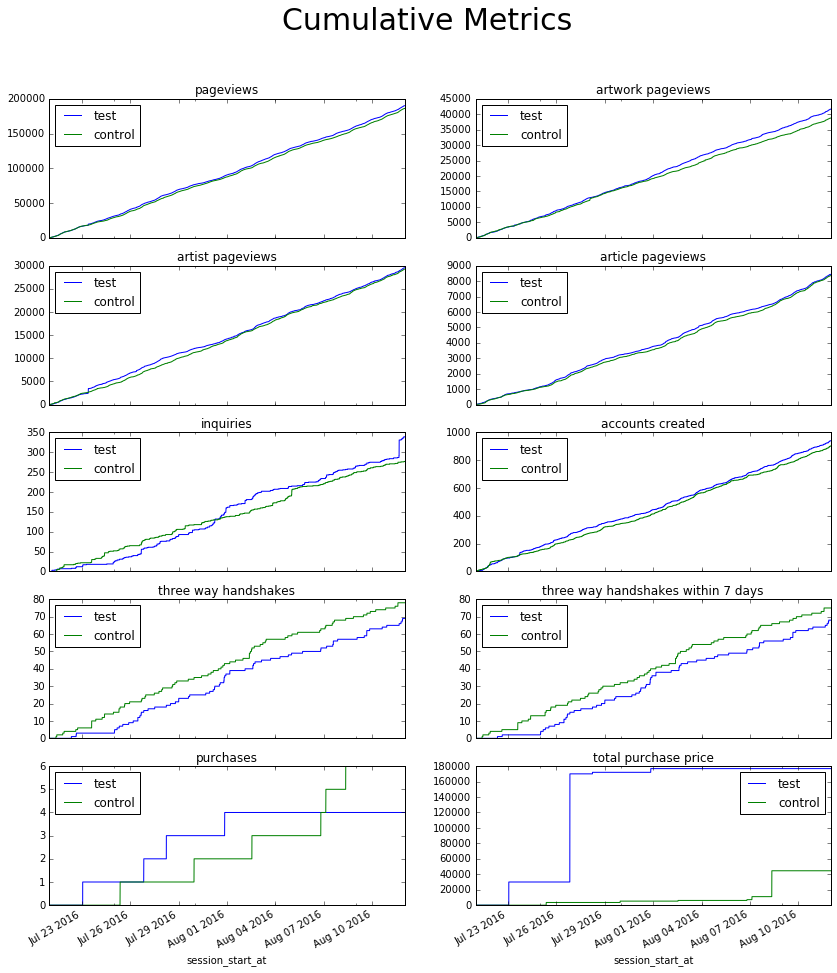

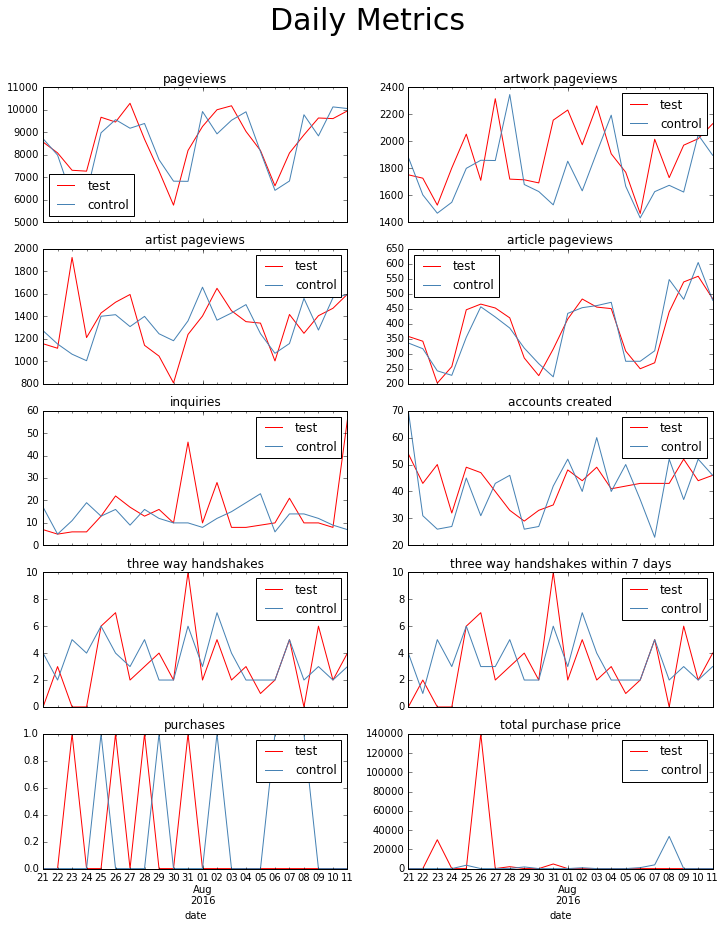

In [11]:
# cumulative plots
cumulative_plot(test, control)

# daily plots
daily_plot(test, control)

(1, 50)

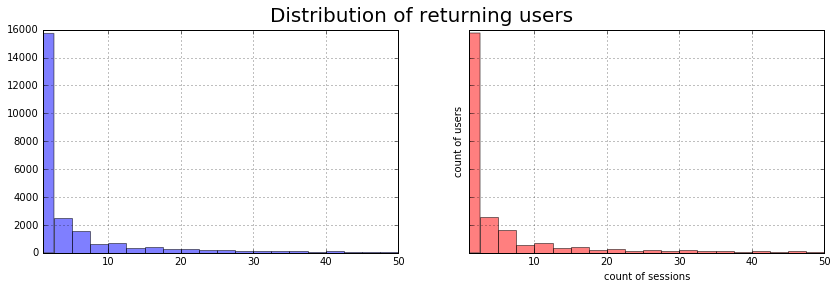

In [235]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,4), sharex=True, sharey=True)
plt.suptitle('Distribution of returning users', fontsize=20); 
plt.ylabel('count of users')
plt.xlabel('count of sessions')

control.session_number.astype(float).hist(ax=axes[0], bins=20,range=(0,50),alpha=0.5,color='b')
plt.xlim([1,50])

test.session_number.astype(float).hist(ax=axes[1], bins=20,range=(0,50),alpha=0.5,color='r')
plt.xlim([1,50])

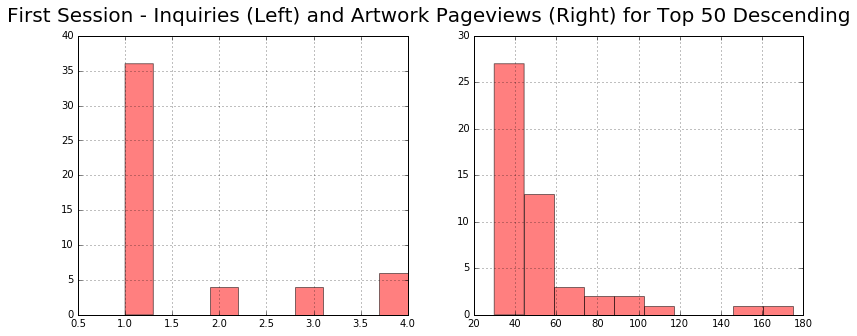

In [237]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,4))

test_sums = test.loc[test.session_number==1].groupby('looker_visitor_id')[['count_artwork_pv', 'inquiries']].sum()
test_sums.inquiries.sort_values(ascending=False).head(50).hist(ax=axes[0], figsize=(13,5), alpha=0.5, color='r')
test_sums.count_artwork_pv.sort_values(ascending=False).head(50).hist(ax=axes[1], figsize=(13,5), alpha=0.5, color='r')

plt.suptitle('First Session - Inquiries (Left) and Artwork Pageviews (Right) for Top 50 Descending', fontsize=20); 

In [238]:
print 'control: ', control[control.purchases>0][['looker_visitor_id','count_pv','total_purchase_price']]
print 'test:    ', test[test.purchases>0][['looker_visitor_id','count_pv','total_purchase_price']]

control:                                          looker_visitor_id  count_pv  \
session_start_at                                                      
2016-07-25 08:59:23              549f02507261695171b51000         7   
2016-07-29 22:57:06              4fcf86b3322a1d00040009ec        10   
2016-08-02 12:58:48              56b19e7cc9dc246406000078        13   
2016-08-06 19:26:25  2b3209a3-c1c0-4c50-b3af-981834293e6c         4   
2016-08-07 02:55:41  a7f2e9fc-1d28-41a6-9841-430864df46d7         5   

                     total_purchase_price  
session_start_at                           
2016-07-25 08:59:23                3500.0  
2016-07-29 22:57:06                1750.0  
2016-08-02 12:58:48                 890.8  
2016-08-06 19:26:25                1000.0  
2016-08-07 02:55:41                3900.0  
test:                                 looker_visitor_id  count_pv  total_purchase_price
session_start_at                                                             
2016-07-23 01:25:0

In [110]:
exp_logged_status = sql("""
    SELECT exp.variation_id,
           fins.*,
           SPLIT_PART(fins.session_id,' - ',1) as session_number,
           afmps.logged_in
    FROM (SELECT DISTINCT session_id,
                 variation_id,
                 experiment_id
          FROM analytics.force_mapped_experiment_viewed afmev
          WHERE afmev.experiment_id = '%s') exp
      LEFT JOIN analytics.force_inquiry_funnel_sessions fins
             ON exp.session_id = fins.session_id
            AND exp.variation_id is not null
      LEFT JOIN (select distinct session_id,
                        logged_in
                from analytics.force_mapped_pages) afmps
                on afmps.session_id = fins.session_id
    WHERE (session_start_at >= '%s' AND session_start_at <= '%s') LIMIT 5000000
"""%('personalized_homepage', '2016-07-21', '2016-08-09'))

exp_logged_status['date'] = exp_logged_status.session_start_at.values.astype('datetime64[D]')
exp_logged_status['outcome'] = (exp_logged_status.inquiries > 0).astype('int')
exp_logged_status = exp_logged_status.set_index('session_start_at').sort_index()

In [111]:
exp_logged_status.groupby('logged_in').sum()

,count_pv,count_artwork_pv,count_artist_pv,count_article_pv,inquiries,three_way_handshakes,three_way_handshakes_within_seven_days,purchases,total_purchase_price,accounts_created,outcome
logged_in,,,,,,,,,,,
False,287248,61423,43999,12720,366,94,91,4,174390.8,1580,254
True,83795,19907,16166,2640,431,100,96,6,42940.8,1398,262


In [112]:
control_logged_status = exp_logged_status.loc[exp_logged_status.variation_id.isin(defaults)]
test_logged_status = exp_logged_status.loc[~exp_logged_status.variation_id.isin(defaults)]

In [113]:
control_logged_status.groupby('logged_in').sum()

,count_pv,count_artwork_pv,count_artist_pv,count_article_pv,inquiries,three_way_handshakes,three_way_handshakes_within_seven_days,purchases,total_purchase_price,accounts_created,outcome
logged_in,,,,,,,,,,,
False,142968,30069,22074,6362,177,52,50,2,4390.8,777,130
True,40572,9514,7910,1226,207,54,51,3,6140.8,688,130


In [114]:
test_logged_status.groupby('logged_in').sum()

,count_pv,count_artwork_pv,count_artist_pv,count_article_pv,inquiries,three_way_handshakes,three_way_handshakes_within_seven_days,purchases,total_purchase_price,accounts_created,outcome
logged_in,,,,,,,,,,,
False,144280,31354,21925,6358,189,42,41,2,170000.0,803,124
True,43223,10393,8256,1414,224,46,45,3,36800.0,710,132


We have more purchases in the full data set - selecting distinct `session_id` from `force_mapped_pages` is filtering out information

In [115]:
control_logged_status.groupby(['logged_in','outcome']).sum()

count_pv  count_artwork_pv  count_artist_pv  \
logged_in outcome                                                
False     0          140595             29217            21585   
          1            2373               852              489   
True      0           37979              8534             7304   
          1            2593               980              606   

                   count_article_pv  inquiries  three_way_handshakes  \
logged_in outcome                                                      
False     0                    6345          0                     0   
          1                      17        177                    52   
True      0                    1200          0                     0   
          1                      26        207                    54   

                   three_way_handshakes_within_seven_days  purchases  \
logged_in outcome                                                      
False     0                                             0          0   
          1                                            50          2   
True      0                                             0          0   
          1                                            51          3   

                   total_purchase_price  accounts_created  
logged_in outcome                                          
False     0                         0.0               736  
          1                      4390.8                41  
True      0                         0.0               651  
          1                      6140.8                37

In [116]:
test_logged_status.groupby(['logged_in','outcome']).sum()

count_pv  count_artwork_pv  count_artist_pv  \
logged_in outcome                                                
False     0          141628             30399            21394   
          1            2652               955              531   
True      0           39943              9105             7604   
          1            3280              1288              652   

                   count_article_pv  inquiries  three_way_handshakes  \
logged_in outcome                                                      
False     0                    6329          0                     0   
          1                      29        189                    42   
True      0                    1376          0                     0   
          1                      38        224                    46   

                   three_way_handshakes_within_seven_days  purchases  \
logged_in outcome                                                      
False     0                                             0          0   
          1                                            41          2   
True      0                                             0          0   
          1                                            45          3   

                   total_purchase_price  accounts_created  
logged_in outcome                                          
False     0                         0.0               763  
          1                    170000.0                40  
True      0                         0.0               675  
          1                     36800.0                35

In [117]:
exp_logged_status[exp_logged_status.session_id == '2 - 570c28658b3b817d2d003a14']

,variation_id,session_id,looker_visitor_id,landing_page_path,exit_page_path,first_referrer,first_referrer_source,first_referrer_medium,campaign_name,campaign_content,city,country,count_pv,count_artwork_pv,count_artist_pv,count_article_pv,inquiries,three_way_handshakes,three_way_handshakes_within_seven_days,purchases,total_purchase_price,accounts_created,session_number,logged_in,date,outcome
session_start_at,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-07-21 00:09:16,new_homepage_5,2 - 570c28658b3b817d2d003a14,570c28658b3b817d2d003a14,/reset_password,/search,None,None,direct,None,None,Port Orchard,US,10,0,3,0,0,0,0,0,0.0,0,2,True,2016-07-21,0
2016-07-21 00:09:16,new_homepage_5,2 - 570c28658b3b817d2d003a14,570c28658b3b817d2d003a14,/reset_password,/search,None,None,direct,None,None,Port Orchard,US,10,0,3,0,0,0,0,0,0.0,0,2,False,2016-07-21,0


In [118]:
print 'total sessions in original df:              ', (25624.000000 + 25862.000000)
print 'total sessions after considering logged-in: ', len(exp_logged_status)

total sessions in original df:               51486.0
total sessions after considering logged-in:  54550


In [119]:
control_logged_status.groupby(['logged_in','outcome','variation_id']).sum()

count_pv  count_artwork_pv  count_artist_pv  \
logged_in outcome variation_id                                                  
False     0       old_homepage_1     26731              5565             3825   
                  old_homepage_2     27658              6048             4202   
                  old_homepage_3     29391              5761             4714   
                  old_homepage_4     28839              6319             4457   
                  old_homepage_5     27976              5524             4387   
          1       old_homepage_1       613               238              153   
                  old_homepage_2       335                95               76   
                  old_homepage_3       583               213               78   
                  old_homepage_4       522               218               92   
                  old_homepage_5       320                88               90   
True      0       old_homepage_1      7834              1759             1458   
                  old_homepage_2      7323              1524             1423   
                  old_homepage_3      7621              1747             1412   
                  old_homepage_4      7502              2011             1245   
                  old_homepage_5      7699              1493             1766   
          1       old_homepage_1       706               283              167   
                  old_homepage_2       415               124              152   
                  old_homepage_3       516               221               66   
                  old_homepage_4       430               164               87   
                  old_homepage_5       526               188              134   

                                  count_article_pv  inquiries  \
logged_in outcome variation_id                                  
False     0       old_homepage_1              1275          0   
                  old_homepage_2              1286          0   
                  old_homepage_3              1287          0   
                  old_homepage_4              1276          0   
                  old_homepage_5              1221          0   
          1       old_homepage_1                 3         43   
                  old_homepage_2                 6         31   
                  old_homepage_3                 3         47   
                  old_homepage_4                 1         36   
                  old_homepage_5                 4         20   
True      0       old_homepage_1               245          0   
                  old_homepage_2               274          0   
                  old_homepage_3               247          0   
                  old_homepage_4               219          0   
                  old_homepage_5               215          0   
          1       old_homepage_1                 6         54   
                  old_homepage_2                 3         30   
                  old_homepage_3                 3         45   
                  old_homepage_4                 1         35   
                  old_homepage_5                13         43   

                                  three_way_handshakes  \
logged_in outcome variation_id                           
False     0       old_homepage_1                     0   
                  old_homepage_2                     0   
                  old_homepage_3                     0   
                  old_homepage_4                     0   
                  old_homepage_5                     0   
          1       old_homepage_1                    14   
                  old_homepage_2                    12   
                  old_homepage_3                    12   
                  old_homepage_4                     8   
                  old_homepage_5                     6   
True      0       old_homepage_1                     0   
                  old_homepage_2                     0   
        

In [120]:
test_logged_status.groupby(['logged_in','outcome','variation_id']).sum()

count_pv  count_artwork_pv  count_artist_pv  \
logged_in outcome variation_id                                                  
False     0       new_homepage_1     27609              5863             4070   
                  new_homepage_2     31319              7051             5341   
                  new_homepage_3     28316              5923             4074   
                  new_homepage_4     27645              6011             3850   
                  new_homepage_5     26739              5551             4059   
          1       new_homepage_1       552               234               88   
                  new_homepage_2       555               188              112   
                  new_homepage_3       530               165              136   
                  new_homepage_4       393               169               54   
                  new_homepage_5       622               199              141   
True      0       new_homepage_1      7719              1849             1619   
                  new_homepage_2      8422              2125             1655   
                  new_homepage_3      7635              1711             1387   
                  new_homepage_4      7761              1903             1358   
                  new_homepage_5      8406              1517             1585   
          1       new_homepage_1       912               408              143   
                  new_homepage_2       476               170               94   
                  new_homepage_3       666               241              152   
                  new_homepage_4       360               152               54   
                  new_homepage_5       866               317              209   

                                  count_article_pv  inquiries  \
logged_in outcome variation_id                                  
False     0       new_homepage_1              1237          0   
                  new_homepage_2              1333          0   
                  new_homepage_3              1222          0   
                  new_homepage_4              1296          0   
                  new_homepage_5              1241          0   
          1       new_homepage_1                 5         36   
                  new_homepage_2                 4         30   
                  new_homepage_3                 6         48   
                  new_homepage_4                10         31   
                  new_homepage_5                 4         44   
True      0       new_homepage_1               210          0   
                  new_homepage_2               264          0   
                  new_homepage_3               288          0   
                  new_homepage_4               266          0   
                  new_homepage_5               348          0   
          1       new_homepage_1                12         46   
                  new_homepage_2                 4         25   
                  new_homepage_3                 5         55   
                  new_homepage_4                 9         32   
                  new_homepage_5                 8         66   

                                  three_way_handshakes  \
logged_in outcome variation_id                           
False     0       new_homepage_1                     0   
                  new_homepage_2                     0   
                  new_homepage_3                     0   
                  new_homepage_4                     0   
                  new_homepage_5                     0   
          1       new_homepage_1                     7   
                  new_homepage_2                     3   
                  new_homepage_3                    17   
                  new_homepage_4                     5   
                  new_homepage_5                    10   
True      0       new_homepage_1                     0   
                  new_homepage_2                     0   
        

In [156]:
both_logged = exp_logged_status.groupby('session_id').logged_in.nunique()

In [157]:
both_logged = both_logged[both_logged > 1]

In [158]:
len(both_logged)

3064

In [161]:
exp_logged_status[exp_logged_status.session_id.isin(both_logged.index)]

,variation_id,session_id,looker_visitor_id,landing_page_path,exit_page_path,first_referrer,first_referrer_source,first_referrer_medium,campaign_name,campaign_content,city,country,count_pv,count_artwork_pv,count_artist_pv,count_article_pv,inquiries,three_way_handshakes,three_way_handshakes_within_seven_days,purchases,total_purchase_price,accounts_created,session_number,logged_in,date,outcome
session_start_at,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-07-21 00:09:16,new_homepage_5,2 - 570c28658b3b817d2d003a14,570c28658b3b817d2d003a14,/reset_password,/search,None,None,direct,None,None,Port Orchard,US,10,0,3,0,0,0,0,0,0.0,0,2,True,2016-07-21,0
2016-07-21 00:09:16,new_homepage_5,2 - 570c28658b3b817d2d003a14,570c28658b3b817d2d003a14,/reset_password,/search,None,None,direct,None,None,Port Orchard,US,10,0,3,0,0,0,0,0,0.0,0,2,False,2016-07-21,0
2016-07-21 00:24:30,new_homepage_3,1 - 579016557622dd65da000df8,579016557622dd65da000df8,/sign_up/,/,None,seattle-art-fair-2016,email,seattle-art-fair-2016-partnership-announcement...,None,Bellevue,US,3,0,0,0,0,0,0,0,0.0,1,1,True,2016-07-21,0
2016-07-21 00:24:30,new_homepage_3,1 - 579016557622dd65da000df8,579016557622dd65da000df8,/sign_up/,/,None,seattle-art-fair-2016,email,seattle-art-fair-2016-partnership-announcement...,None,Bellevue,US,3,0,0,0,0,0,0,0,0.0,1,1,False,2016-07-21,0
2016-07-21 00:29:54,new_homepage_4,1 - 579017c02a893a65d80014be,579017c02a893a65d80014be,/sign_up/,/,None,seattle-art-fair-2016,email,seattle-art-fair-2016-partnership-announcement...,None,Seattle,US,3,0,0,0,0,0,0,0,0.0,1,1,True,2016-07-21,0
2016-07-21 00:29:54,new_homepage_4,1 - 579017c02a893a65d80014be,579017c02a893a65d80014be,/sign_up/,/,None,seattle-art-fair-2016,email,seattle-art-fair-2016-partnership-announcement...,None,Seattle,US,3,0,0,0,0,0,0,0,0.0,1,1,False,2016-07-21,0
2016-07-21 00:40:39,old_homepage_2,9 - 557de1877261696f060009dd,557de1877261696f060009dd,/artist/janet-werner,/collect,https://www.google.ca/,Google,search,None,None,None,None,8,0,3,0,0,0,0,0,0.0,0,9,False,2016-07-21,0
2016-07-21 00:40:39,old_homepage_2,9 - 557de1877261696f060009dd,557de1877261696f060009dd,/artist/janet-werner,/collect,https://www.google.ca/,Google,search,None,None,None,None,8,0,3,0,0,0,0,0,0.0,0,9,True,2016-07-21,0
2016-07-21 00:53:12,new_homepage_1,2 - 57901d3b139b21317e005dae,57901d3b139b21317e005dae,/professional-buyer,/artists,None,mailchimp,email,pro-buyer,None,None,None,7,0,0,0,0,0,0,0,0.0,1,2,True,2016-07-21,0


In [12]:
sessions_during_exp = exp.groupby('looker_visitor_id').session_number.nunique()

In [13]:
len(sessions_during_exp)

48850

In [17]:
for i in range(1,21):
    print '# users with %s sessions: '%i , len(sessions_during_exp[sessions_during_exp == i])

# users with 1 sessions:  43308
# users with 2 sessions:  3648
# users with 3 sessions:  929
# users with 4 sessions:  391
# users with 5 sessions:  163
# users with 6 sessions:  86
# users with 7 sessions:  82
# users with 8 sessions:  46
# users with 9 sessions:  46
# users with 10 sessions:  27
# users with 11 sessions:  26
# users with 12 sessions:  16
# users with 13 sessions:  11
# users with 14 sessions:  10
# users with 15 sessions:  4
# users with 16 sessions:  9
# users with 17 sessions:  6
# users with 18 sessions:  2
# users with 19 sessions:  5
# users with 20 sessions:  4


In [14]:
for i in range(0,21):
    print '# users with more than %s sessions: '%i , len(sessions_during_exp[sessions_during_exp > i])

# users with more than 0 sessions:  48850
# users with more than 1 sessions:  5542
# users with more than 2 sessions:  1894
# users with more than 3 sessions:  965
# users with more than 4 sessions:  574
# users with more than 5 sessions:  411
# users with more than 6 sessions:  325
# users with more than 7 sessions:  243
# users with more than 8 sessions:  197
# users with more than 9 sessions:  151
# users with more than 10 sessions:  124
# users with more than 11 sessions:  98
# users with more than 12 sessions:  82
# users with more than 13 sessions:  71
# users with more than 14 sessions:  61
# users with more than 15 sessions:  57
# users with more than 16 sessions:  48
# users with more than 17 sessions:  42
# users with more than 18 sessions:  40
# users with more than 19 sessions:  35
# users with more than 20 sessions:  31


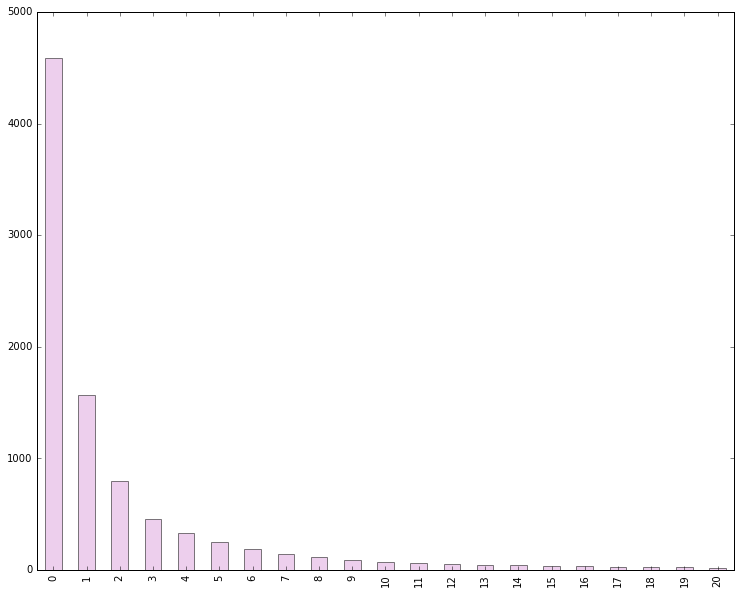

In [242]:
pd.Series([len(sessions_during_exp[sessions_during_exp > i]) for i in range(1,22)]).plot(kind='bar',
                                                                                         color='plum',
                                                                                         alpha=0.5)

# change the value below to compare

In [243]:
more_than_one_session = sessions_during_exp[sessions_during_exp > 5]

In [244]:
len(more_than_one_session)

328

In [245]:
df_multi_sessions = exp[exp.looker_visitor_id.isin(more_than_one_session.index)]

In [246]:
defaults = ['default', 'original',
            'old_homepage_1', 'old_homepage_2', 'old_homepage_3', 'old_homepage_4', 'old_homepage_5']

In [247]:
control_more_than_one_session = df_multi_sessions[df_multi_sessions.variation_id.isin(defaults)]

In [248]:
test_more_than_one_session = df_multi_sessions[~df_multi_sessions.variation_id.isin(defaults)]

In [249]:
control_more_than_one_session[control_more_than_one_session.session_number > 50]._get_numeric_data().mean()

count_pv                                    6.873502
count_artwork_pv                            1.291611
count_artist_pv                             1.684421
count_article_pv                            0.139814
inquiries                                   0.000000
three_way_handshakes                        0.000000
three_way_handshakes_within_seven_days      0.000000
purchases                                   0.000000
total_purchase_price                        0.000000
accounts_created                            0.000000
session_number                            168.356858
outcome                                     0.000000
dtype: float64

In [250]:
test_more_than_one_session[test_more_than_one_session.session_number > 50]._get_numeric_data().mean()

count_pv                                    6.419643
count_artwork_pv                            1.757653
count_artist_pv                             1.183673
count_article_pv                            0.179847
inquiries                                   0.001276
three_way_handshakes                        0.000000
three_way_handshakes_within_seven_days      0.000000
purchases                                   0.000000
total_purchase_price                        0.000000
accounts_created                            0.000000
session_number                            171.959184
outcome                                     0.001276
dtype: float64

In [251]:
control_more_than_one_session._get_numeric_data().mean()

count_pv                                   7.139988
count_artwork_pv                           1.799757
count_artist_pv                            1.430919
count_article_pv                           0.154595
inquiries                                  0.006695
three_way_handshakes                       0.001217
three_way_handshakes_within_seven_days     0.001217
purchases                                  0.000000
total_purchase_price                       0.000000
accounts_created                           0.001217
session_number                            87.662203
outcome                                    0.003652
dtype: float64

In [252]:
test_more_than_one_session._get_numeric_data().mean()

count_pv                                   6.983266
count_artwork_pv                           1.778419
count_artist_pv                            1.213503
count_article_pv                           0.192152
inquiries                                  0.000577
three_way_handshakes                       0.000000
three_way_handshakes_within_seven_days     0.000000
purchases                                  0.000000
total_purchase_price                       0.000000
accounts_created                           0.000000
session_number                            88.618003
outcome                                    0.000577
dtype: float64

In [253]:
control_more_than_one_session.exit_page_path.value_counts()[control_more_than_one_session.exit_page_path.value_counts()>=15]

/                 779
/collect           50
/works-for-you     36
/search            34
/articles          16
/artists           15
/galleries         15
Name: exit_page_path, dtype: int64

In [254]:
test_more_than_one_session.exit_page_path.value_counts()[test_more_than_one_session.exit_page_path.value_counts()>=15]

/                 778
/collect           67
/search            30
/artists           23
/works-for-you     22
/user/saves        20
Name: exit_page_path, dtype: int64

In [255]:
homepage_pv = sql("""
SELECT sent_at::DATE,
       looker_visitor_id,
       logged_in, --might not be necessary
       COUNT(*)
FROM analytics.force_pages
WHERE (event IN ('/','')
OR    event IS NULL)
AND sent_at >= '2016-07-21'
GROUP BY 1,
         2,
         3  --might not be necessary
ORDER BY sent_at::DATE DESC
""")

In [256]:
homepage_pv.sent_at = homepage_pv.sent_at.values.astype('datetime64[D]')

In [257]:
control.date.head()

session_start_at
2016-07-21 00:01:46   2016-07-21
2016-07-21 00:02:03   2016-07-21
2016-07-21 00:04:14   2016-07-21
2016-07-21 00:04:33   2016-07-21
2016-07-21 00:07:48   2016-07-21
Name: date, dtype: datetime64[ns]

In [258]:
homepage_pv.head()

,sent_at,looker_visitor_id,logged_in,count
0,2016-08-10,73b83a4b-bc09-4912-923c-246953ab009b,False,1
1,2016-08-10,ea91d9b7-15e0-45ad-9086-42a5f1ac222c,False,1
2,2016-08-10,2f71af88-408f-44b8-89aa-b9ed3adf08c2,False,2
3,2016-08-10,87107e48-f76e-4671-922c-9a7a67c71f72,False,1
4,2016-08-10,0c506a6b-a87e-4b22-95ef-7e308df226b5,False,1


In [259]:
control_with_homepage = pd.merge(control, homepage_pv, how='left', left_on=['date', 'looker_visitor_id'], right_on=['sent_at','looker_visitor_id'])
test_with_homepage    = pd.merge(test, homepage_pv, how ='left', left_on=['date', 'looker_visitor_id'], right_on=['sent_at','looker_visitor_id'])

In [260]:
# control_with_homepage = pd.merge(control, homepage_pv, how='left', on='looker_visitor_id')
# test_with_homepage    = pd.merge(test, homepage_pv, how ='left', on='looker_visitor_id')

In [261]:
control_with_homepage.groupby('looker_visitor_id').sum().mean()

count_pv                                   7.965103
count_artwork_pv                           1.702949
count_artist_pv                            1.262536
count_article_pv                           0.339835
inquiries                                  0.013098
three_way_handshakes                       0.003776
three_way_handshakes_within_seven_days     0.003633
purchases                                  0.000239
total_purchase_price                       0.527788
accounts_created                           0.048042
session_number                            17.820928
outcome                                    0.008748
count                                      1.831235
dtype: float64

In [262]:
test_with_homepage.groupby('looker_visitor_id').sum().mean()

count_pv                                   8.196726
count_artwork_pv                           1.822794
count_artist_pv                            1.289982
count_article_pv                           0.343388
inquiries                                  0.014556
three_way_handshakes                       0.003150
three_way_handshakes_within_seven_days     0.003102
purchases                                  0.000191
total_purchase_price                       8.437933
accounts_created                           0.050064
session_number                            17.797261
outcome                                    0.009259
count                                      1.833285
dtype: float64

In [263]:
control_homepage_more_than_one_session = pd.merge(control_more_than_one_session, homepage_pv, how='left', left_on=['date', 'looker_visitor_id'], right_on=['sent_at','looker_visitor_id'])
test_homepage_more_than_one_session = pd.merge(test_more_than_one_session, homepage_pv, how='left', left_on=['date', 'looker_visitor_id'], right_on=['sent_at','looker_visitor_id'])

In [277]:
test_with_homepage.looker_visitor_id.nunique()

20953

In [264]:
print len(control_homepage_more_than_one_session)
print len(test_homepage_more_than_one_session)

1663
1738


In [265]:
control_homepage_more_than_one_session.groupby('looker_visitor_id').sum().mean()

count_pv                                   77.275641
count_artwork_pv                           19.416667
count_artist_pv                            15.243590
count_article_pv                            1.788462
inquiries                                   0.070513
three_way_handshakes                        0.012821
three_way_handshakes_within_seven_days      0.012821
purchases                                   0.000000
total_purchase_price                        0.000000
accounts_created                            0.025641
session_number                            935.512821
outcome                                     0.038462
count                                      36.935897
dtype: float64

In [266]:
test_homepage_more_than_one_session.groupby('looker_visitor_id').sum().mean()

count_pv                                   70.633721
count_artwork_pv                           18.029070
count_artist_pv                            12.255814
count_article_pv                            1.936047
inquiries                                   0.005814
three_way_handshakes                        0.000000
three_way_handshakes_within_seven_days      0.000000
purchases                                   0.000000
total_purchase_price                        0.000000
accounts_created                            0.000000
session_number                            897.313953
outcome                                     0.005814
count                                      27.645349
dtype: float64

In [267]:
control_homepage_more_than_one_session[control_homepage_more_than_one_session.logged_in==False].groupby('looker_visitor_id').sum().mean()

count_pv                                   70.878261
count_artwork_pv                           17.330435
count_artist_pv                            13.304348
count_article_pv                            1.504348
inquiries                                   0.000000
three_way_handshakes                        0.000000
three_way_handshakes_within_seven_days      0.000000
purchases                                   0.000000
total_purchase_price                        0.000000
accounts_created                            0.017391
session_number                            663.973913
outcome                                     0.000000
count                                      38.817391
dtype: float64

In [268]:
test_homepage_more_than_one_session[test_homepage_more_than_one_session.logged_in==False].groupby('looker_visitor_id').sum().mean()

count_pv                                   63.409836
count_artwork_pv                           17.106557
count_artist_pv                            10.918033
count_article_pv                            2.057377
inquiries                                   0.000000
three_way_handshakes                        0.000000
three_way_handshakes_within_seven_days      0.000000
purchases                                   0.000000
total_purchase_price                        0.000000
accounts_created                            0.000000
session_number                            533.459016
outcome                                     0.000000
count                                      28.729508
dtype: float64

In [269]:
control_homepage_more_than_one_session[control_homepage_more_than_one_session.logged_in==True].groupby('looker_visitor_id').sum().mean()

count_pv                                    71.132075
count_artwork_pv                            19.207547
count_artist_pv                             15.773585
count_article_pv                             1.830189
inquiries                                    0.207547
three_way_handshakes                         0.037736
three_way_handshakes_within_seven_days       0.037736
purchases                                    0.000000
total_purchase_price                         0.000000
accounts_created                             0.037736
session_number                            1238.679245
outcome                                      0.113208
count                                       24.490566
dtype: float64

In [270]:
test_homepage_more_than_one_session[test_homepage_more_than_one_session.logged_in==True].groupby('looker_visitor_id').sum().mean()

count_pv                                    80.092593
count_artwork_pv                            18.296296
count_artist_pv                             14.166667
count_article_pv                             1.462963
inquiries                                    0.018519
three_way_handshakes                         0.000000
three_way_handshakes_within_seven_days       0.000000
purchases                                    0.000000
total_purchase_price                         0.000000
accounts_created                             0.000000
session_number                            1614.574074
outcome                                      0.018519
count                                       23.148148
dtype: float64

In [271]:
test_session_logged_in = test_homepage_more_than_one_session[test_homepage_more_than_one_session.logged_in==True][test_homepage_more_than_one_session.session_number>50]

In [272]:
test_session_logged_in.groupby('looker_visitor_id').sum().mean()

count_pv                                    66.804878
count_artwork_pv                            19.048780
count_artist_pv                             12.585366
count_article_pv                             1.292683
inquiries                                    0.024390
three_way_handshakes                         0.000000
three_way_handshakes_within_seven_days       0.000000
purchases                                    0.000000
total_purchase_price                         0.000000
accounts_created                             0.000000
session_number                            2063.609756
outcome                                      0.024390
count                                       24.219512
dtype: float64